# House Prices - Advanced Regression Techniq
## 理解题目
给出关于房价的一些信息，通过这些信息来预测对应的房价
## 数据准备

In [28]:
import pandas as pd
import numpy as np
import random

#Visualization
import pandas_profiling as ppf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor

In [13]:
# 读入数据
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
combin = [train_df, test_df]

## 理解数据

In [14]:
#ppf.ProfileReport(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 清洗数据
### 查看缺失值多所占比列

In [15]:
#查看缺失值所占比列
train_df_total = train_df.isnull().sum().sort_values(ascending=False)
train_df_percent=(train_df.isnull().sum()/len(train_df)).sort_values(ascending=False)
test_df_total = test_df.isnull().sum().sort_values(ascending=False)
test_df_percent=(test_df.isnull().sum()/len(test_df)).sort_values(ascending=False)
type_df = train_df.dtypes
missing_data = pd.concat([train_df_total, train_df_percent, test_df_total, test_df_percent, type_df], axis=1, keys=['train__missing', 'percent','test__missing','percent', 'dtype'])
missing_data[missing_data.sum(axis=1,numeric_only=True) > 0]

,train__missing,percent,test__missing,percent,dtype
PoolQC,1453,0.995205,1456.0,0.997944,object
MiscFeature,1406,0.963014,1408.0,0.965045,object
Alley,1369,0.937671,1352.0,0.926662,object
Fence,1179,0.807534,1169.0,0.801234,object
FireplaceQu,690,0.472603,730.0,0.500343,object
LotFrontage,259,0.177397,227.0,0.155586,float64
GarageYrBlt,81,0.055479,78.0,0.053461,float64
GarageCond,81,0.055479,78.0,0.053461,object
GarageType,81,0.055479,76.0,0.052090,object
GarageFinish,81,0.055479,78.0,0.053461,object


### 解决缺失值
PoolQC, MiscFeature, Alley, Fence 这四个变量缺失较多，可直接剔除整列，其他剩下的缺失值可用一些特殊值补充。

In [16]:
# 直接剔除这三个特征
drop_column = ['PoolQC','MiscFeature', 'Alley', 'Fence']
train_df.drop(drop_column, axis=1, inplace=True)
test_df.drop(drop_column, axis=1, inplace=True)

# 缺失值列表，第一个中nan代表没有，第二个为数值型，第三个为对象型
missing_none = ['FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']
missing_num = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtHalfBath','BsmtHalfBath', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1']
missing_obj = ['MasVnrType', 'Electrical', 'Functional','KitchenQual', 'SaleType', 'Utilities', 'MSZoning', 'Exterior2nd', 'Exterior1st']

# 填补缺失值
for df in combin:
    for col in missing_none:
        df[col] = df[col].fillna('none')
    for col in missing_num:
        df[col] = df[col].fillna(df[col].mean())
    for col in missing_obj:
        df[col] = df[col].fillna(df[col].mode()[0])

现在再来检查一下缺失值

In [17]:
#查看缺失值所占比列
train_df_total = train_df.isnull().sum().sort_values(ascending=False)
train_df_percent=(train_df.isnull().sum()/len(train_df)).sort_values(ascending=False)
test_df_total = test_df.isnull().sum().sort_values(ascending=False)
test_df_percent=(test_df.isnull().sum()/len(test_df)).sort_values(ascending=False)
type_df = train_df.dtypes
missing_data = pd.concat([train_df_total, train_df_percent, test_df_total, test_df_percent, type_df], axis=1, keys=['train__missing', 'percent','test__missing','percent', 'dtype'])
missing_data

,train__missing,percent,test__missing,percent,dtype
Id,0,0.0,0.0,0.0,int64
HalfBath,0,0.0,0.0,0.0,int64
FireplaceQu,0,0.0,0.0,0.0,object
Fireplaces,0,0.0,0.0,0.0,int64
Functional,0,0.0,0.0,0.0,object
...,...,...,...,...,...
MasVnrArea,0,0.0,0.0,0.0,float64
MasVnrType,0,0.0,0.0,0.0,object
Exterior2nd,0,0.0,0.0,0.0,object
Exterior1st,0,0.0,0.0,0.0,object


从上面的表格可以看到目前已经没有缺失值了。

## 特征工程

### 数据类型装换

In [18]:
# 将数字类别型转换为字符类别型
num_to_str = ['MSSubClass', 'OverallQual', 'YrSold', 'MoSold']
for df in combin:
    for col in num_to_str:
        df[col] = df[col].astype(str)
            
# one-hot编码
train_df_dummy = pd.get_dummies(train_df)
test_df_dummy = pd.get_dummies(test_df)

# 解决train test编码不一致
#求出两者的列名不同，以及确定需要补充的zeros矩阵shape
train_columns = [column for column in train_df_dummy]
test_columns = [column for column in test_df_dummy]
diff = [i for i in train_columns if i not in test_columns]
new = np.zeros((len(test_df),len(diff)))
new = pd.DataFrame(new,columns=diff)
test_df_dummy = pd.concat([test_df_dummy,new],axis=1)
print(diff)

# 解决train test编码不一致
#求出两者的列名不同，以及确定需要补充的zeros矩阵shape
diff = [i for i in test_columns if i not in train_columns]
new = np.zeros((len(train_df),len(diff)))
new = pd.DataFrame(new,columns=diff)
print('***********')
print(diff)
train_df_dummy = pd.concat([train_df_dummy,new],axis=1)
test_df_dummy.drop('SalePrice',axis=1, inplace=True)
train_df_dummy.shape, test_df_dummy.shape

['SalePrice', 'Utilities_NoSeWa', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin', 'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW', 'Electrical_Mix', 'GarageQual_Ex']
***********
['MSSubClass_150']


((1460, 326), (1459, 325))

### 特征选择
选择和价格相关的特征，丢掉一些不需要的特征，通过相关性来判断

In [19]:
# 计算相关性并剔除相关性低于|0.15|的特征
corr = train_df_dummy.corr(method='pearson')
low_corr = corr['SalePrice'][(corr['SalePrice'] < 0.15) & (corr['SalePrice'] > -0.15)].index
low_corr = low_corr.to_list()
train_df_dummy.drop(low_corr,axis=1,inplace=True)
test_df_dummy.drop(low_corr,axis=1,inplace=True)

## 评估算法
### 数据集划分
这一部分，可以使用随机划分，或者是随机抽样，分层抽样等，sklearn都有相应的库函数进行调用， 分离完训练集和测试集之后，测试集放在一边不用管，拿训练集进行下面的模型评估

In [177]:
# 划分训练集和测试集
X_train = train_df_dummy.drop('SalePrice', axis=1)
Y_train = train_df_dummy['SalePrice']
X_test = test_df_dummy.copy()

# 标准化
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

X_train.shape, Y_train.shape, X_test.shape

((1460, 105), (1460,), (1459, 105))

### 评估模型

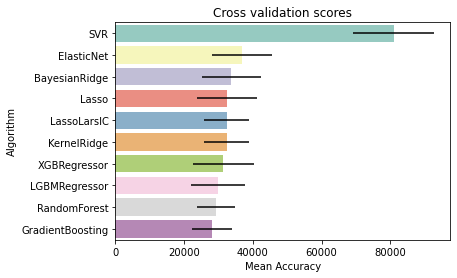

In [21]:
# Cross validate model with Kfold stratified cross val
kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Modeling step Test differents algorithms 
Regressors = []
Regressors.append(ElasticNet())
Regressors.append(Lasso())
Regressors.append(BayesianRidge())
Regressors.append(LassoLarsIC())
Regressors.append(RandomForestRegressor())
Regressors.append(GradientBoostingRegressor())
Regressors.append(KernelRidge())
Regressors.append(SVR())
Regressors.append(LGBMRegressor())
Regressors.append(XGBRegressor())

cv_results = []
for regressor in Regressors:
    cv_results.append(np.sqrt(-cross_val_score(regressor, X_train, Y_train, scoring = "neg_mean_squared_error", cv = kf, n_jobs=-1)))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["ElasticNet","Lasso","BayesianRidge",
"LassoLarsIC","RandomForest","GradientBoosting","KernelRidge","SVR","LGBMRegressor","XGBRegressor"]})

cv_res.sort_values(by=["CrossValMeans"], ascending=False, inplace=True)
g = sns.barplot(x="CrossValMeans",y="Algorithm", data=cv_res,palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## 优化模型
###  算法调参
从上面表现比较好的模型中选出2-3个，可以尝试进行合理的参数搜索，找到合适的参数。
选择排名较高的模型，GradientBossting, RandomForest, LGBMRegressor这三个模型，分别调参选择最合适的参数

In [22]:
# GradientBossting
GBR = GradientBoostingRegressor()

## Search grid for optimal parameters
rf_param_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                }

gsGBR = GridSearchCV(GBR,param_grid = rf_param_grid, cv=kf, scoring="neg_mean_squared_error", n_jobs= -1, verbose = 1)

gsGBR.fit(X_train,Y_train)

GBR_best = gsGBR.best_estimator_

# Best score
gsGBR.best_score_

Fitting 10 folds for each of 256 candidates, totalling 2560 fits


-722057646.188995

In [23]:
# RandomForest
RFR = RandomForestRegressor()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None, 1, 2, 3],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[500,700,1000],
              "criterion": ["squared_error"]}


gsRFR = GridSearchCV(RFR,param_grid = rf_param_grid, cv=kf, scoring="neg_mean_squared_error", n_jobs= -1, verbose = 1)

gsRFR.fit(X_train,Y_train)

RFR_best = gsRFR.best_estimator_

# Best score
gsRFR.best_score_

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


-789233242.3297012

In [24]:
# LGBMRegressor

LGBMR = LGBMRegressor()

## Search grid for optimal parameters
rf_param_grid = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

gsLGBMR = GridSearchCV(LGBMR,param_grid = rf_param_grid, cv=kf, scoring="neg_mean_squared_error", n_jobs= -1, verbose = 1)

gsLGBMR.fit(X_train,Y_train)

LGBMR_best = gsLGBMR.best_estimator_

# Best score
gsLGBMR.best_score_

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


-812447559.5585997

In [25]:
# XGBRegressor()
XGBR = XGBRegressor()

## Search grid for optimal parameters
rf_param_grid = {"learning_rate": (0.05, 0.10, 0.15),
                "max_depth": [ 3, 4, 5, 6, 8],
                "min_child_weight": [ 1, 3, 5, 7],
                "gamma":[ 0.0, 0.1, 0.2],
                "colsample_bytree":[ 0.3, 0.4],
                "n_estimators": [500]}


gsXGBR = GridSearchCV(XGBR,param_grid = rf_param_grid, cv=kf, scoring="neg_mean_squared_error", n_jobs= -1, verbose = 1)

gsXGBR.fit(X_train,Y_train)

XGBR_best = gsXGBR.best_estimator_

# Best score
gsXGBR.best_score_

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


-753844630.652252

In [34]:
# Stacking
estimators = [
    ('gbr', GBR_best),
    ('rfr', RFR_best),
    ('lgbmr', LGBMR_best)
]

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=XGBR_best
)

reg.fit(X_train,Y_train)

StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.03,
                                                         max_depth=4,
                                                         n_estimators=500,
                                                         subsample=0.5)),
                              ('rfr',
                               RandomForestRegressor(bootstrap=False,
                                                     max_features=10,
                                                     n_estimators=700)),
                              ('lgbmr',
                               LGBMRegressor(max_depth=5, n_estimators=500,
                                             num_leaves=7))],
                  final_estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                               colsample_byle...
                                               gamma=0.0, gpu_id=-1,
                      

In [36]:
Y_pred = pd.Series(reg.predict(X_test), name="SalePrice")

test_df = pd.read_csv('input/test.csv')

submission = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": Y_pred
    })
submission.to_csv('output/submission.csv', index=False)
submission

F:\Anaconda3\envs\kaggle\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
F:\Anaconda3\envs\kaggle\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,Id,SalePrice
0,1461,147325.421875
1,1462,175843.781250
2,1463,220419.203125
3,1464,201636.468750
4,1465,178782.406250
...,...,...
1454,2915,103491.882812
1455,2916,93984.984375
1456,2917,203098.515625
1457,2918,144845.687500


## 参考
https://zhuanlan.zhihu.com/p/107752696
https://codeleading.com/article/76832061981/